## Dependencies

In [1]:
import warnings, json, random, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

SEED = 0
seed_everything(SEED)
warnings.filterwarnings('ignore')

# Model parameters

In [2]:
config = {
  "BATCH_SIZE": 64,
  "EPOCHS": 120,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "PB_SEQ_LEN": 107,
  "PV_SEQ_LEN": 130,
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BATCH_SIZE': 64,
 'EPOCHS': 120,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'PB_SEQ_LEN': 107,
 'PV_SEQ_LEN': 130}

# Load data

In [3]:
database_base_path = '/kaggle/input/stanford-covid-vaccine/'
train = pd.read_json(database_base_path + 'train.json', lines=True)
test = pd.read_json(database_base_path + 'test.json', lines=True)

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 2400


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


Test samples: 3634


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Auxiliary functions

In [4]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
token2int_seq = {x:i for i, x in enumerate('ACGU')}
token2int_struct = {x:i for i, x in enumerate('().')}
token2int_loop = {x:i for i, x in enumerate('BEHIMSX')}

def plot_metrics(history):
    metric_list = [m for m in list(history_list[0].keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
        axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_metrics_agg(history_list):
    metric_list = [m for m in list(history_list[0].keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 6))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, history in enumerate(history_list):
        for index in range(len(metric_list)//2):
            metric_name = metric_list[index]
            val_metric_name = metric_list[index+size]
            axes[index].plot(history[metric_name], label=f'Train {metric_name}_Fold{idx+1}')
            axes[index].plot(history[val_metric_name], label=f'Valid {metric_name}_Fold{idx+1}')
            axes[index].legend(loc='best', fontsize=16)
            axes[index].set_title(metric_name)
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

def preprocess_inputs(df, encoder, cols=['sequence', 'structure', 'predicted_loop_type']):
    input_lists = df[cols].applymap(lambda seq: [encoder[x] for x in seq]).values.tolist()
    return np.transpose(np.array(input_lists), (0, 2, 1))

def evaluate_model(df, y_true, y_pred, target_cols):
    # Complete data
    metrics = []
    metrics_clean_sn = []
    metrics_noisy_sn = []
    metrics_clean_sig = []
    metrics_noisy_sig = []
    
    for idx, col in enumerate(pred_cols):
        metrics.append(np.sqrt(np.mean((y_true[:, :, idx] - y_pred[:, :, idx])**2)))
        
    target_cols = ['Overall'] + target_cols
    metrics = [np.mean(metrics)] + metrics
    
    # SN_filter = 1
    idxs = df[df['SN_filter'] == 1].index
    for idx, col in enumerate(pred_cols):
        metrics_clean_sn.append(np.sqrt(np.mean((y_true[idxs, :, idx] - y_pred[idxs, :, idx])**2)))
        
    metrics_clean_sn = [np.mean(metrics_clean_sn)] + metrics_clean_sn
    
    # SN_filter = 0
    idxs = df[df['SN_filter'] == 0].index
    for idx, col in enumerate(pred_cols):
        metrics_noisy_sn.append(np.sqrt(np.mean((y_true[idxs, :, idx] - y_pred[idxs, :, idx])**2)))
        
    metrics_noisy_sn = [np.mean(metrics_noisy_sn)] + metrics_noisy_sn
    
    # signal_to_noise > 1
    idxs = df[df['signal_to_noise'] > 1].index
    for idx, col in enumerate(pred_cols):
        metrics_clean_sig.append(np.sqrt(np.mean((y_true[idxs, :, idx] - y_pred[idxs, :, idx])**2)))
        
    metrics_clean_sig = [np.mean(metrics_clean_sig)] + metrics_clean_sig
    
    # signal_to_noise <= 1
    idxs = df[df['signal_to_noise'] <= 1].index
    for idx, col in enumerate(pred_cols):
        metrics_noisy_sig.append(np.sqrt(np.mean((y_true[idxs, :, idx] - y_pred[idxs, :, idx])**2)))
        
    metrics_noisy_sig = [np.mean(metrics_noisy_sig)] + metrics_noisy_sig
    
    metrics_df = pd.DataFrame({'Metric/MCRMSE': target_cols, 'Complete': metrics, 'Clean (SN)': metrics_clean_sn, 
                               'Noisy (SN)': metrics_noisy_sn, 'Clean (signal)': metrics_clean_sig, 
                               'Noisy (signal)': metrics_noisy_sig})
    return metrics_df

def get_dataset(x, y=None, labeled=True, shuffled=True, batch_size=32, buffer_size=-1, seed=0):
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'inputs_seq': x[:, 0, :, :], 
                                                       'inputs_struct': x[:, 1, :, :], 
                                                       'inputs_loop': x[:, 2, :, :]}, 
                                                      {'outputs': y}))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(({'inputs_seq': x[:, 0, :, :], 
                                                       'inputs_struct': x[:, 1, :, :], 
                                                       'inputs_loop': x[:, 2, :, :]}))
    
    
    if shuffled:
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def get_dataset_sampling(x, y=None, shuffled=True, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'inputs_seq': x[:, 0, :, :], 
                                                   'inputs_struct': x[:, 1, :, :], 
                                                   'inputs_loop': x[:, 2, :, :]}, 
                                                  {'outputs': y}))
    
    
    if shuffled:
        dataset = dataset.shuffle(2048, seed=seed)
    
    return dataset

# Model

In [5]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

def model_fn(embed_dim=75, hidden_dim=128, dropout=.5, sp_dropout=.2, pred_len=68, n_outputs=5):    
    inputs_seq  = L.Input(shape=(None, 1), name='inputs_seq')  
    inputs_struct  = L.Input(shape=(None, 1), name='inputs_struct')  
    inputs_loop  = L.Input(shape=(None, 1), name='inputs_loop')

    shared_embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim, name='shared_embedding')
    embed_seq = shared_embed(inputs_seq)
    embed_struct = shared_embed(inputs_struct)
    embed_loop = shared_embed(inputs_loop)
    
    x_concat = L.concatenate([embed_seq, embed_struct, embed_loop], axis=2, name='embedding_concatenate')
    x_reshaped = L.Reshape((-1, x_concat.shape[2]*x_concat.shape[3]))(x_concat)
    
    x = L.SpatialDropout1D(sp_dropout)(x_reshaped)

    x = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))(x)
    
    x_1 = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))(x)
    x = L.Add()([x_1, x])
    
    x_2 = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))(x)
    x = L.Add()([x_2, x])
    
    # Since we are only making predictions on the first part of each sequence, we have to truncate it
    x_truncated = x[:, :pred_len]
    
    outputs = L.Dense(n_outputs, activation='linear', name='outputs')(x_truncated)

    model = Model(inputs=[inputs_seq, inputs_struct, inputs_loop], outputs=outputs)

    opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    model.compile(optimizer=opt, loss=MCRMSE)

    return model

model = model_fn()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_seq (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_struct (InputLayer)      [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_loop (InputLayer)        [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    (None, None, 1, 75)  1050        inputs_seq[0][0]                 
                                                                 inputs_struct[0][0]   

# Pre-process

In [6]:
feature_cols = ['sequence', 'structure', 'predicted_loop_type']
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
encoder_list = [token2int, token2int, token2int]

train_features = np.array([preprocess_inputs(train, encoder_list[idx], [col]) for idx, col in enumerate(feature_cols)]).transpose((1, 0, 2, 3))
train_labels = np.array(train[pred_cols].values.tolist()).transpose((0, 2, 1))

public_test = test.query("seq_length == 107").copy()
private_test = test.query("seq_length == 130").copy()

x_test_public = np.array([preprocess_inputs(public_test, encoder_list[idx], [col]) for idx, col in enumerate(feature_cols)]).transpose((1, 0, 2, 3))
x_test_private = np.array([preprocess_inputs(private_test, encoder_list[idx], [col]) for idx, col in enumerate(feature_cols)]).transpose((1, 0, 2, 3))

# To use as stratified col
train['signal_to_noise_int'] = train['signal_to_noise'].astype(int)

# Training

In [7]:
AUTO = tf.data.experimental.AUTOTUNE
skf = StratifiedKFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
history_list = []

oof = train[['id']].copy()
oof_preds = np.zeros(train_labels.shape)
test_public_preds = np.zeros((x_test_public.shape[0], config['PB_SEQ_LEN'], len(pred_cols)))
test_private_preds = np.zeros((x_test_private.shape[0], config['PV_SEQ_LEN'], len(pred_cols)))

for fold,(train_idx, valid_idx) in enumerate(skf.split(train_labels, train['signal_to_noise_int'])):
    if fold >= config['N_USED_FOLDS']:
        break
    print(f'\nFOLD: {fold+1}')

    ### Create datasets
#     x_train = train_features[train_idx]
    y_train = train_labels[train_idx]
    x_valid = train_features[valid_idx]
    y_valid = train_labels[valid_idx]
    
#     train_ds = get_dataset(x_train, y_train, labeled=True, shuffled=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    valid_ds = get_dataset(x_valid, y_valid, labeled=True, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    oof_ds = get_dataset(train_features[valid_idx], labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_public_ds = get_dataset(x_test_public, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_private_ds = get_dataset(x_test_private, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    
    # Create clean and noisy datasets
    clean_idxs = np.intersect1d(train[train['signal_to_noise'] > 1].index, train_idx)
    noisy_idxs = np.intersect1d(train[train['signal_to_noise'] <= 0].index, train_idx)  
    clean_ds = get_dataset_sampling(train_features[clean_idxs], train_labels[clean_idxs], shuffled=True, seed=SEED)
    noisy_ds = get_dataset_sampling(train_features[noisy_idxs], train_labels[noisy_idxs], shuffled=True, seed=SEED)
    # Resampled TF Dataset
    resampled_ds = tf.data.experimental.sample_from_datasets([clean_ds, noisy_ds], weights=[.95, .05])
    resampled_ds = resampled_ds.batch(config['BATCH_SIZE']).prefetch(AUTO)


    ### Model
    K.clear_session()
    model = model_fn()

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], restore_best_weights=True, verbose=1)
    rlrp = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, verbose=1)
    
    ### Train
    history = model.fit(resampled_ds,
                        validation_data=valid_ds,
                        callbacks=[es, rlrp], 
                        epochs=config['EPOCHS'], 
                        batch_size=config['BATCH_SIZE'],
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    ### Inference
    oof_preds[valid_idx] = model.predict(oof_ds)
    
    # Short sequence (public test)
    model = model_fn(pred_len= config['PB_SEQ_LEN'])
    model.load_weights(model_path)
    test_public_preds += model.predict(test_public_ds) * (1 / config['N_USED_FOLDS'])
    
    # Long sequence (private test)
    model = model_fn(pred_len= config['PV_SEQ_LEN'])
    model.load_weights(model_path)
    test_private_preds += model.predict(test_private_ds) * (1 / config['N_USED_FOLDS'])


FOLD: 1
Epoch 1/120
28/28 - 3s - loss: 0.5554 - val_loss: 0.6240
Epoch 2/120
28/28 - 1s - loss: 0.4985 - val_loss: 0.6066
Epoch 3/120
28/28 - 1s - loss: 0.4825 - val_loss: 0.5943
Epoch 4/120
28/28 - 1s - loss: 0.4720 - val_loss: 0.5862
Epoch 5/120
28/28 - 2s - loss: 0.4612 - val_loss: 0.5736
Epoch 6/120
28/28 - 1s - loss: 0.4527 - val_loss: 0.5693
Epoch 7/120
28/28 - 1s - loss: 0.4458 - val_loss: 0.5631
Epoch 8/120
28/28 - 1s - loss: 0.4418 - val_loss: 0.5581
Epoch 9/120
28/28 - 1s - loss: 0.4382 - val_loss: 0.5562
Epoch 10/120
28/28 - 1s - loss: 0.4368 - val_loss: 0.5513
Epoch 11/120
28/28 - 1s - loss: 0.4307 - val_loss: 0.5476
Epoch 12/120
28/28 - 1s - loss: 0.4270 - val_loss: 0.5436
Epoch 13/120
28/28 - 1s - loss: 0.4232 - val_loss: 0.5391
Epoch 14/120
28/28 - 1s - loss: 0.4209 - val_loss: 0.5386
Epoch 15/120
28/28 - 1s - loss: 0.4160 - val_loss: 0.5329
Epoch 16/120
28/28 - 1s - loss: 0.4126 - val_loss: 0.5279
Epoch 17/120
28/28 - 1s - loss: 0.4098 - val_loss: 0.5274
Epoch 18/120
2

## Model loss graph


FOLD: 1
Train 0.32765 Validation 0.46225

FOLD: 2
Train 0.35705 Validation 0.35899

FOLD: 3
Train 0.35631 Validation 0.37521

FOLD: 4
Train 0.35807 Validation 0.39196

FOLD: 5
Train 0.34658 Validation 0.38408


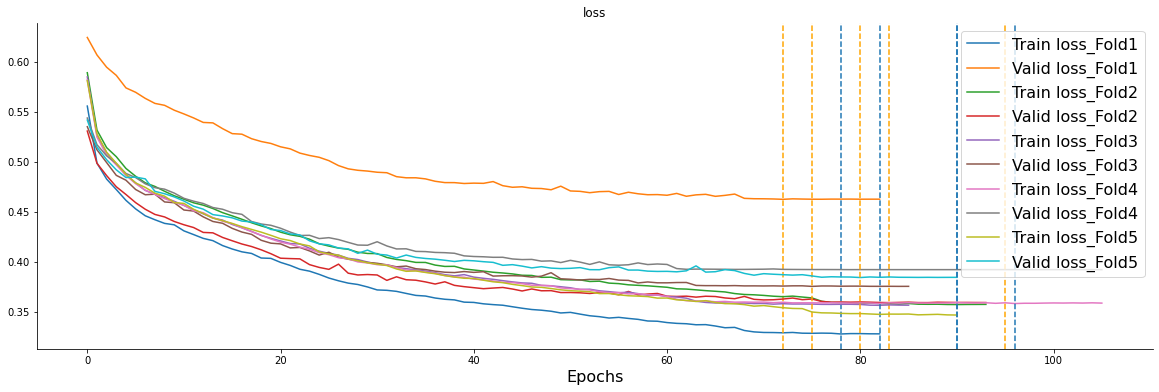

In [8]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    print(f"Train {np.array(history['loss']).min():.5f} Validation {np.array(history['val_loss']).min():.5f}")

plot_metrics_agg(history_list)

# Post-processing

In [9]:
# Assign values to OOF set
# Assign labels
for idx, col in enumerate(pred_cols):
    val = train_labels[:, :, idx]
    oof = oof.assign(**{col: list(val)})

# Assign preds
for idx, col in enumerate(pred_cols):
    val = oof_preds[:, :, idx]
    oof = oof.assign(**{f'{col}_pred': list(val)})
    

# Assign values to test set
preds_ls = []

for df, preds in [(public_test, test_public_preds), (private_test, test_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

# Model evaluation

In [10]:
display(evaluate_model(train, train_labels, oof_preds, pred_cols))

,Metric/MCRMSE,Complete,Clean (SN),Noisy (SN),Clean (signal),Noisy (signal)
0,Overall,0.826481,0.235610,1.377850,0.249787,2.218212
1,reactivity,0.613208,0.225254,1.006656,0.227019,1.616562
2,deg_Mg_pH10,0.549123,0.268209,0.866828,0.267551,1.373679
3,deg_pH10,1.177431,0.249368,1.995190,0.274271,3.228958
4,deg_Mg_50C,0.741877,0.222215,1.237740,0.237572,1.988964
5,deg_50C,1.050765,0.213003,1.782834,0.242524,2.882897


# Visualize test predictions

In [11]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission = submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])

# Test set predictions

In [12]:
display(submission.head(10))
display(submission.describe())

submission.to_csv('submission.csv', index=False)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.713841,0.655501,2.016715,0.582525,0.792083
1,id_00073f8be_1,2.292375,3.201296,4.417741,3.232319,2.853283
2,id_00073f8be_2,1.460313,0.594271,0.669741,0.751387,0.785292
3,id_00073f8be_3,1.299531,1.111198,1.275155,1.681062,1.718678
4,id_00073f8be_4,0.877458,0.584102,0.644060,0.871310,0.929462
5,id_00073f8be_5,0.699789,0.694342,0.819167,0.773640,0.855970
6,id_00073f8be_6,0.385449,0.687188,0.760324,0.662003,0.736685
7,id_00073f8be_7,0.403780,0.718605,0.872785,0.660985,0.931063
8,id_00073f8be_8,0.105436,0.384433,0.465728,0.428305,0.405495
9,id_00073f8be_9,0.086826,0.195064,0.231071,0.220839,0.327654


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
count,457953.000000,457953.000000,457953.000000,457953.000000,457953.000000
mean,0.320226,0.397184,0.372044,0.331420,0.354623
std,0.353654,0.386186,0.421151,0.378973,0.329204
min,-0.402938,-1.481251,-3.281725,-2.637980,-2.706987
25%,0.073998,0.174869,0.136219,0.089342,0.118372
50%,0.201832,0.289420,0.274747,0.239320,0.288001
75%,0.471518,0.478464,0.469962,0.465221,0.517376
max,3.376185,4.667032,5.850098,4.136468,3.586329
